In [20]:
# !pip install protobuf==4.25.1
# !pip install tensorflow==2.14
# !pip install numpy
# !pip install plotly
# !pip install scikit-learn
# !pip install pandas
# !pip install matplotlib
# !pip install contractions
# !pip install nltk
# !pip install nbformat>=4.2.0
# !pip install fasttext
# !pip install keras-self-attention

# LIBRARY

In [16]:
import pandas as pd
import numpy as np
import time
import re
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten, Attention, Input, concatenate, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras_self_attention import SeqSelfAttention

import keras
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.text import Tokenizer

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import fasttext

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import contractions
from contractions import contractions_dict

from collections import Counter

loc = "/content/gdrive/MyDrive/code/data/"
loc_data = "/content/gdrive/MyDrive/code/data/dataClean"

dataset_name = 'data/covid_articles_raw.csv'


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
print(tf.config.list_physical_devices('GPU'))


print(tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
))

print(tf.config.experimental.list_physical_devices('GPU'))


[]
False
[]


# LOAD DATASET

In [21]:
data_raw = pd.read_csv(dataset_name)
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 477551 entries, 0 to 477550
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   title     477551 non-null  object
 1   content   477548 non-null  object
 2   category  477539 non-null  object
dtypes: object(3)
memory usage: 10.9+ MB


## FILTER

In [22]:
Text = "title"
Label = "category"

data_Clean = data_raw[[Text,Label]].copy().dropna()

data_Clean.rename(columns = {Text:'Text',Label:'Label'}, inplace = True)

data_Clean.info()
data_Clean.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 477539 entries, 0 to 477550
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Text    477539 non-null  object
 1   Label   477539 non-null  object
dtypes: object(2)
memory usage: 10.9+ MB


,Text,Label
0,Looking into the truth about modern workplace ...,general
1,Hexo refiles financial statements,general
2,"Japan raid, Turkey arrests in widening Ghosn p...",general
3,Pope's bodyguards criticised over slapping inc...,general
4,Lebanon denies president welcomed fugitive Ghosn,general
5,Lebanese lawyers want Ghosn prosecuted over Is...,general
6,"' I did it alone ', Ghosn says of Japan escape",general
7,Ghosn escape sparks calls to toughen Japan's b...,general
8,Mexico's Santiago River has become a toxic 'en...,general
9,Fired British vegan files landmark discriminat...,general


## VISUALIZATION

In [23]:
groups = data_Clean.groupby(by='Label').count()['Text']
fig = go.Figure()
fig.add_trace(go.Bar(
    x=groups.index,
    y=groups,
    marker_color='cadetblue',
    width=[0.4, 0.4]))

fig.update_layout(title='Classes and their number in the dataset', title_x=0.5)

In [40]:
large_groups = data_Clean.groupby(by='Label').count()['Text']
groups = large_groups[large_groups > 10000]
fig = go.Figure()
fig.add_trace(go.Bar(
    x=groups.index,
    y=groups,
    marker_color='cadetblue',
    width=[0.4, 0.4]))

fig.update_layout(title='Classes and their number in the dataset', title_x=0.5)

In [41]:
data_text =  data_Clean.loc[data_Clean['Label'].isin(groups.index)].reset_index(drop=True)
# Xóa ký tự '\n'
data_text['Text'] = data_text['Text'].apply(lambda x: x.replace('\n', ' '))

data_text.head()

,Text,Label
0,Looking into the truth about modern workplace ...,general
1,Hexo refiles financial statements,general
2,"Japan raid, Turkey arrests in widening Ghosn p...",general
3,Pope's bodyguards criticised over slapping inc...,general
4,Lebanon denies president welcomed fugitive Ghosn,general


# PRE-PROCESSING

In [42]:
def pre_Processing(data):
  '''
  # Đổi văn bản thô sang văn bản gốc
  Ví dụ:
        He played football while she was playing tennis. The request was denied. He goes to school. She bakes cakes. I'm gonna go to the store
        He play football while she be play tennis . The request be deny . He go to school . She bake cake . I be go to go to the store
  '''
  def lemmatization_and_stemming(text):
    lemmatization =  ' '.join([contractions_dict.get(word, word) for word in text.split()])
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in lemmatization.split()])

  # Hàm loại bỏ stop words
  def remove_stop_words(text):
      # Lấy danh sách stop words tiếng Anh
      stop_words = set(stopwords.words('english'))
      words = text.split()
      filtered_words = [word for word in words if word not in stop_words]
      return ' '.join(filtered_words)
  
  # đưa các từ viết tắt về nguyên mẫu
  data['Text'] = data['Text'].apply(lemmatization_and_stemming)

  # đưa về chữ thường
  data['Text'] = data['Text'].str.lower()
  
  # loại bỏ ký tự đặc biệt và số
  data['Text'] = data['Text'].apply(lambda x: re.sub('[^a-z]', ' ', str(x)))

  # Xóa từ dừng
  data['Text'] = data['Text'].apply(remove_stop_words)
  # loại các text null
  data = data[data['Text'] != ""]

  return data[['Text', 'Label']]

data_processing = pre_Processing(data_text)

name_data_processing = "data/covid_processing.csv"
# Xuất DataFrame thành file .csv
data_processing.to_csv(name_data_processing, index=False, encoding='utf-8')

data_processing.info()
data_processing.head()

<class 'pandas.core.frame.DataFrame'>
Index: 467328 entries, 0 to 467397
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Text    467328 non-null  object
 1   Label   467328 non-null  object
dtypes: object(2)
memory usage: 10.7+ MB


,Text,Label
0,looking truth modern workplace environments,general
1,hexo refiles financial statements,general
2,japan raid turkey arrest widen ghosn probe,general
3,pope bodyguards criticise slap incident,general
4,lebanon deny president welcome fugitive ghosn,general


In [26]:
data_sample = data_processing.copy()
data_sample["length"] = data_sample["Text"].apply(lambda x: len(x.split()))
data_sample["length"].describe()

count    477459.000000
mean          8.178407
std           2.771871
min           1.000000
25%           6.000000
50%           8.000000
75%           9.000000
max         259.000000
Name: length, dtype: float64

# Tokenizer

In [2]:
# name_data_processing = "data/covid_processing.csv"
# data_processing = pd.read_csv(name_data_processing, nrows=200000)

# data_tokenizer = data_processing.copy()
# # Tách từ
# data_tokenizer['Text'] = data_tokenizer['Text'].apply(word_tokenize)

# data_tokenizer.info()
# data_tokenizer.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Text    200000 non-null  object
 1   Label   200000 non-null  object
dtypes: object(2)
memory usage: 3.1+ MB


,Text,Label
0,"[looking, truth, modern, workplace, environments]",general
1,"[hexo, refiles, financial, statements]",general
2,"[japan, raid, turkey, arrest, widen, ghosn, pr...",general
3,"[pope, bodyguards, criticise, slap, incident]",general
4,"[lebanon, deny, president, welcome, fugitive, ...",general


In [43]:
name_data_processing = "data/covid_processing.csv"
data_processing = pd.read_csv(name_data_processing)
data_tokenizer = data_processing.copy()

# Tách từ
data_tokenizer['Text'] = data_tokenizer['Text'].apply(word_tokenize)
# Xuất DataFrame thành file .csv
data_tokenizer.to_csv("data/covid_tokenizer.csv", index=False, encoding='utf-8')
data_tokenizer.info()
data_tokenizer.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467328 entries, 0 to 467327
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Text    467328 non-null  object
 1   Label   467328 non-null  object
dtypes: object(2)
memory usage: 7.1+ MB


,Text,Label
0,"[looking, truth, modern, workplace, environments]",general
1,"[hexo, refiles, financial, statements]",general
2,"[japan, raid, turkey, arrest, widen, ghosn, pr...",general
3,"[pope, bodyguards, criticise, slap, incident]",general
4,"[lebanon, deny, president, welcome, fugitive, ...",general


<class 'pandas.core.frame.DataFrame'>
Index: 212257 entries, 148261 to 223711
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Text    212257 non-null  object
 1   Label   212257 non-null  object
dtypes: object(2)
memory usage: 4.9+ MB


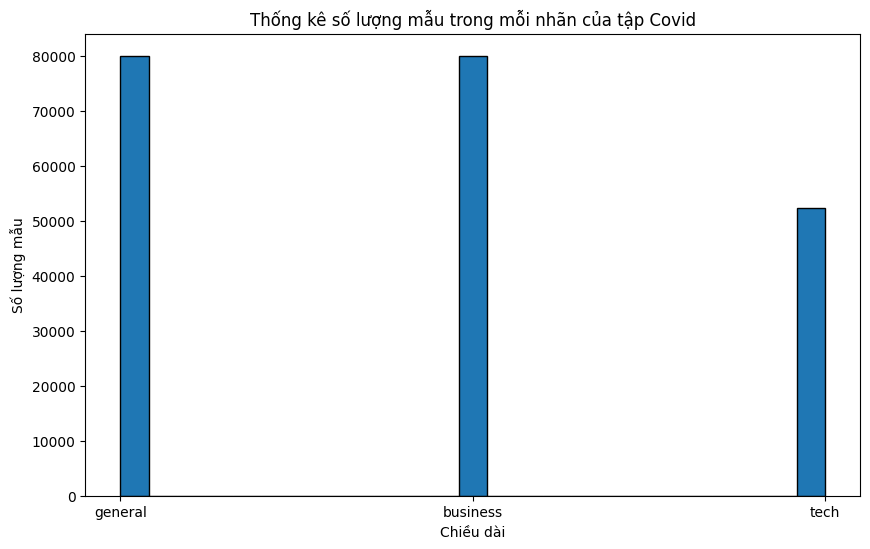

In [83]:
import ast

selected_df = pd.read_csv("data/covid_tokenizer.csv",  converters={'Text': ast.literal_eval})

number_per = 80000
# Khởi tạo danh sách để lưu trữ văn bản đã chọn
data_tokenizer = pd.DataFrame(columns=['Text', 'Label'])

for Label in selected_df["Label"].unique():
    label_indices = selected_df[selected_df['Label'] == Label].index

     
    # Lấy mẫu ngẫu nhiên từ các chỉ mục thuộc nhãn hiện tại
    selected_indices = np.random.choice(label_indices, size=min(number_per, len(label_indices)), replace=False)
    
    # Thêm các dòng đã chọn vào DataFrame mới
    data_tokenizer = pd.concat([data_tokenizer, selected_df.loc[selected_indices]])

data_tokenizer.info()

# Đặt kích thước của hình vẽ
plt.figure(figsize=(10, 6))
# Vẽ biểu đồ tần suất
plt.hist(data_tokenizer["Label"].values, bins=25, edgecolor='black')  # bins là số lượng cột trong histogram
plt.title('Thống kê số lượng mẫu trong mỗi nhãn của tập Covid')
plt.xlabel('Chiều dài')
plt.ylabel('Số lượng mẫu')
plt.show()

# Labels

In [84]:
# encode label
label_encoder = LabelEncoder()
label_encoder.fit(data_tokenizer["Label"].values)

print(data_tokenizer["Label"].nunique())

def encode_label(label):
    return label_encoder.transform(label)

def decode_label(label):
    return label_encoder.inverse_transform(label)


3


In [85]:
max_length = 20

def tokenization(data):
    Text_col = data["Text"]
    tokenizer = Tokenizer(split=' ')
    tokenizer.fit_on_texts(Text_col)
    words_to_index = tokenizer.word_index
    vocab_size = len(words_to_index) + 1
    
    # chuyển đổi dữ liệu văn bản thành các chuỗi số 
    tokenizer_seq = tokenizer.texts_to_sequences(Text_col)

    # Đảm bảo mỗi sequece có cùng độ dài 
    # 'post' có nghĩa là thêm padding vào cuối mỗi sequence
    # 'pre' có nghĩa là thêm padding vào đầu mỗi sequence
    tokenizer_pad = pad_sequences(tokenizer_seq, padding='post', maxlen=max_length)

    return tokenizer_pad, vocab_size, words_to_index

data_tokenizer_pad, vocab_size, words_to_index = tokenization(data_tokenizer)

# Word Embedding - FastText

In [49]:
with open('data/fasttext/text_covid.txt', 'w') as file:
    # Write content to the 
    for i in data_processing["Text"]:
        file.write(i+"\n")

# Training the fastText classifier
model = fasttext.train_unsupervised('data/fasttext/text_covid.txt', maxn=0, dim=100)
model.save_model('model/fasttext/covid_fasttext_100d.bin')

In [86]:
ft = fasttext.load_model('model/fasttext/covid_fasttext_100d.bin')
embed_vector_size = ft.get_word_vector("you").shape[0]

embed_vector_matrix = np.zeros((vocab_size, embed_vector_size))

for word, i in words_to_index.items():
    embedding_vector = ft.get_word_vector(word)
    if any(embedding_vector):
        embed_vector_matrix[i] = embedding_vector
    else:
        embed_vector_matrix[i] = np.random.uniform(low=-1, high=1, size= embed_vector_size)

print(f"Max length | input_length      = {max_length}")
print(f"input_dim  | vocab_size        = {vocab_size}")
print(f"output_dim | embed_vector_size = {embed_vector_size}")
print(f"weights = {embed_vector_matrix.shape}")

embedding = Embedding(input_dim=vocab_size, output_dim=embed_vector_size, 
                      input_length=max_length, weights=[embed_vector_matrix], trainable=False)

Max length | input_length      = 20
input_dim  | vocab_size        = 68931
output_dim | embed_vector_size = 100
weights = (68931, 100)


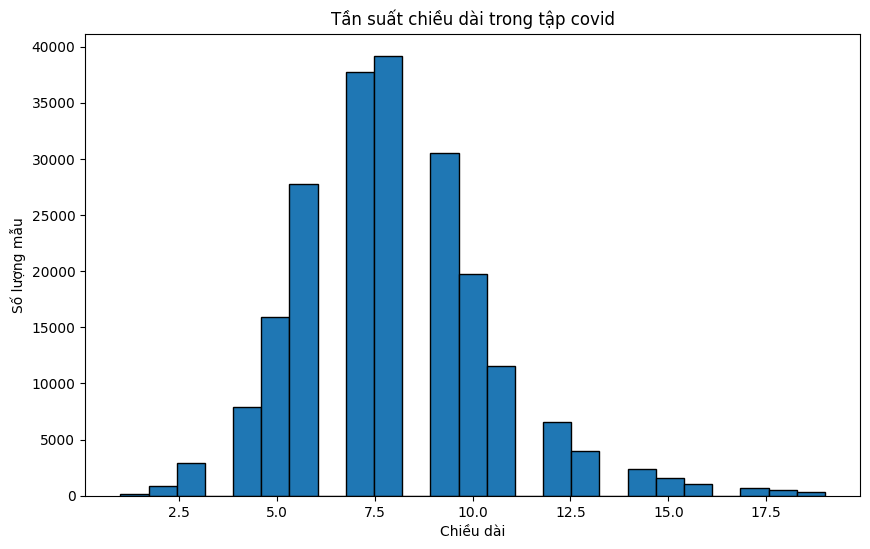

In [89]:
lenght = []
for i in data_tokenizer["Text"].values:
    if len(i) < 20:
        lenght.append(len(i))

# Đặt kích thước của hình vẽ
plt.figure(figsize=(10, 6))
# Vẽ biểu đồ tần suất
plt.hist(lenght, bins=25, edgecolor='black')  # bins là số lượng cột trong histogram
plt.title('Tần suất chiều dài trong tập covid')
plt.xlabel('Chiều dài')
plt.ylabel('Số lượng mẫu')
plt.show()

# Model

In [90]:
classes = data_tokenizer['Label'].nunique()
print(f"Number labels = {classes}")

def create_model(hidden_layers):
    model = Sequential()
    model.add(embedding)
    model.add(LSTM(hidden_layers, return_sequences=True))
    model.add(LSTM(hidden_layers, return_sequences=True))
    model.add(LSTM(hidden_layers, return_sequences=True))
    model.add(SeqSelfAttention())
    model.add(Flatten())
    model.add(Dense(classes, activation="softmax"))

    # Model compiling
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

Number labels = 3


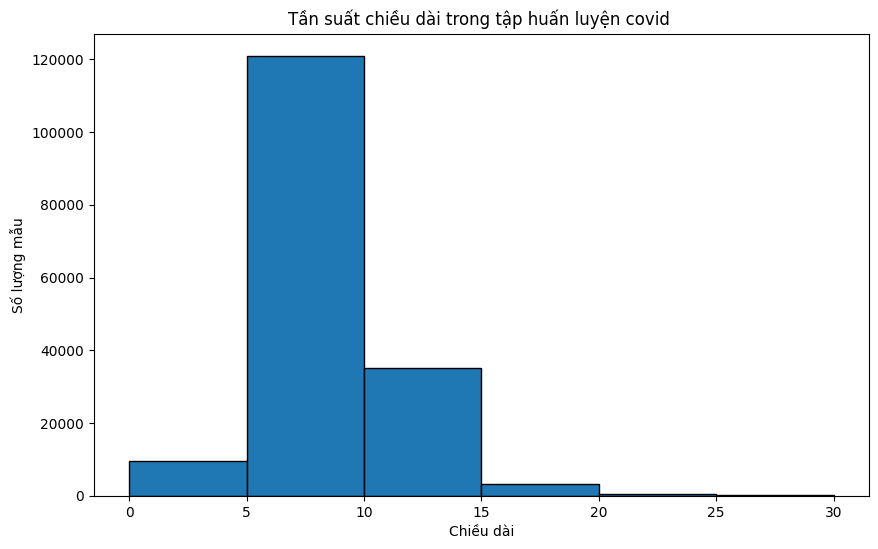

In [91]:
# Chia dataset thành tập training thành train_val và test
X_train_val, X_test = train_test_split(data_tokenizer["Text"], test_size=0.2, random_state=40)
lengths = []
for i in X_train_val:
    lengths.append(len(i))
# Đặt kích thước của hình vẽ
plt.figure(figsize=(10, 6))
# Vẽ biểu đồ tần suất
plt.hist(lengths, bins=[0, 5, 10, 15, 20, 25, 30], edgecolor='black')  # bins là số lượng cột trong histogram
plt.title('Tần suất chiều dài trong tập huấn luyện covid ')
plt.xlabel('Chiều dài')
plt.ylabel('Số lượng mẫu')
plt.show()

# Train_Test_Validation split 

In [92]:
# Chia dataset thành tập training thành train_val và test
X_train_val, X_test, y_train_val, y_test = train_test_split(data_tokenizer_pad, data_tokenizer["Label"].values, test_size=0.2, random_state=40)

# encode label
label_encoder = LabelEncoder()
label_encoder.fit(data_tokenizer["Label"].values)
print('\nLabels:',list(label_encoder.classes_), '\n')
y_train_val = label_encoder.transform(y_train_val)
y_test = label_encoder.transform(y_test)

# Chia train_val thành train và validation
X_train, X_val, y_train, y_val  = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=40)

print("Size Train: ",X_train.shape, y_train.shape)
print("Size Test: ",X_test.shape, y_test.shape)
print("Size Validation: ",X_val.shape, y_val.shape)


Labels: ['business', 'general', 'tech'] 

Size Train:  (127353, 20) (127353,)
Size Test:  (42452, 20) (42452,)
Size Validation:  (42452, 20) (42452,)


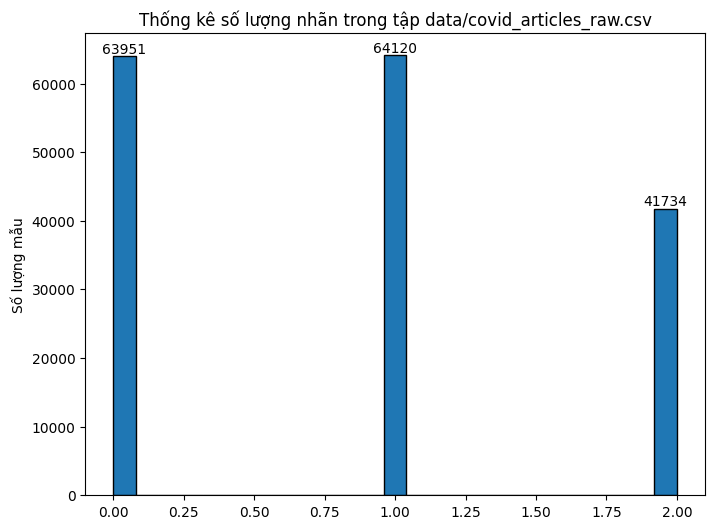

In [93]:
# Đặt kích thước của hình vẽ
plt.figure(figsize=(8, 6))

# Vẽ biểu đồ tần suất
hist, bins, _ = plt.hist(y_train_val, bins=25, edgecolor='black')  # bins là số lượng cột trong histogram

# Thêm số liệu lên đầu của từng cột (loại bỏ số liệu nếu giá trị là 0)
for i in range(len(hist)):
    if hist[i] != 0:
        plt.text(bins[i] + (bins[i + 1] - bins[i]) / 2, hist[i], str(int(hist[i])),
                 ha='center', va='bottom')

plt.title('Thống kê số lượng nhãn trong tập ' + dataset_name)
plt.ylabel('Số lượng mẫu')
plt.show()

# Run

In [94]:
hidden_layers = 100
model = create_model(hidden_layers)
batchSize = round(X_train.shape[0] * 0.045)
epoch = 20
print(batchSize)
model.summary()

5731
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 20, 100)           6893100   
                                                                 
 lstm_6 (LSTM)               (None, 20, 100)           80400     
                                                                 
 lstm_7 (LSTM)               (None, 20, 100)           80400     
                                                                 
 lstm_8 (LSTM)               (None, 20, 100)           80400     
                                                                 
 seq_self_attention_2 (SeqS  (None, 20, 100)           6465      
 elfAttention)                                                   
                                                                 
 flatten_2 (Flatten)         (None, 2000)              0         
                                                 

c:\Users\Administrator\Desktop\text_classification\.venv\lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning:

The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.



In [95]:
# Ghi lại thời điểm bắt đầu
start_time = time.time()

lstm_model_history = model.fit(X_train, y_train, batch_size=batchSize, epochs=epoch, validation_data=(X_val, y_val))

# Tính thời gian đã trôi qua
training_time = round(time.time() - start_time, 2)

Epoch 1/20
23/23 [==============================] - 332s 14s/step - loss: 0.9554 - accuracy: 0.5302 - val_loss: 0.8611 - val_accuracy: 0.5936
Epoch 2/20
23/23 [==============================] - 318s 14s/step - loss: 0.8491 - accuracy: 0.6043 - val_loss: 0.8337 - val_accuracy: 0.6107
Epoch 3/20
23/23 [==============================] - 323s 14s/step - loss: 0.8281 - accuracy: 0.6146 - val_loss: 0.8198 - val_accuracy: 0.6179
Epoch 4/20
23/23 [==============================] - 325s 14s/step - loss: 0.8132 - accuracy: 0.6219 - val_loss: 0.8062 - val_accuracy: 0.6244
Epoch 5/20
23/23 [==============================] - 326s 14s/step - loss: 0.8001 - accuracy: 0.6278 - val_loss: 0.7970 - val_accuracy: 0.6285
Epoch 6/20
23/23 [==============================] - 333s 15s/step - loss: 0.7837 - accuracy: 0.6363 - val_loss: 0.7838 - val_accuracy: 0.6364
Epoch 7/20
23/23 [==============================] - 323s 14s/step - loss: 0.7698 - accuracy: 0.6434 - val_loss: 0.7660 - val_accuracy: 0.6457
Epoch 

In [96]:
# Predictions on the Test Set
score = model.evaluate(X_test, y_test)

# Model Performance
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

1327/1327 [==============================] - 46s 34ms/step - loss: 0.7246 - accuracy: 0.6675
Test Score: 0.7246405482292175
Test Accuracy: 0.6674832701683044


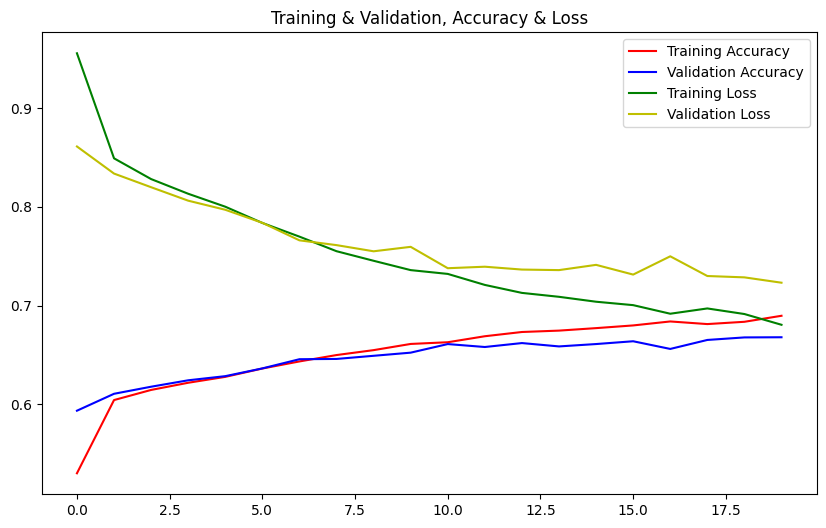

In [97]:
def plot_graph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    
    plt.figure(figsize=(10,6))
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.plot(epochs, loss, 'g', label='Training Loss')
    plt.plot(epochs, val_loss, 'y', label='Validation Loss')
    
    plt.title('Training & Validation, Accuracy & Loss')
    plt.legend(loc=0)
    plt.show()


plot_graph(lstm_model_history)

In [98]:
path = f"model/covid/covid_{max_length}_{X_train.shape[0]}_{batchSize}_{epoch}_{training_time}.h5"
model.save(path)

c:\Users\Administrator\Desktop\text_classification\.venv\lib\site-packages\keras\src\engine\training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [ ]:
# Register the custom object
with tf.keras.utils.custom_object_scope({'SeqSelfAttention': SeqSelfAttention}):
    model = load_model(path)

In [ ]:
# Predictions on the Test Set
score = model.evaluate(X_test, y_test)

# Model Performance
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [99]:

start = None
end = None

# Phân loại 
y_pred = model.predict(X_test[start:end])
# Mã hóa label
y_pred_original = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))
y_test_original = label_encoder.inverse_transform(y_test[start:end])

# In ra kết quả phân loại
print(f"Kết quả thực tế: {y_test_original}")
print(f"Kết quả mô hình phân loại: {y_pred_original} - {y_pred_original == y_test_original}")



1327/1327 [==============================] - 40s 29ms/step
Kết quả thực tế: ['general' 'general' 'business' ... 'general' 'general' 'business']
Kết quả mô hình phân loại: ['tech' 'general' 'business' ... 'general' 'tech' 'business'] - [False  True  True ...  True False  True]


In [100]:
# Tìm tất cả các nhãn duy nhất
labels = np.unique(np.concatenate((y_test_original, y_pred_original)))

# Tạo ma trận confusion
confusion = confusion_matrix(y_test_original, y_pred_original, labels=labels)

print("Ma trận confusion:")
print(confusion)

Ma trận confusion:
[[11068  3301  1680]
 [ 4127  9860  1893]
 [ 1483  1632  7408]]


In [101]:
# Calculate precision, recall, and F1 score for each class
precision_per_class = precision_score(y_test_original, y_pred_original, average=None)
recall_per_class = recall_score(y_test_original, y_pred_original, average=None)
f1_per_class = f1_score(y_test_original, y_pred_original, average=None)

# Calculate macro-average precision, recall, and F1 score
macro_precision = round(np.mean(precision_per_class)*100,1)
macro_recall = round(np.mean(recall_per_class)*100,1)
macro_f1 = round(np.mean(f1_per_class)*100,1)

# Create a DataFrame for the table
metrics_table_per_class = pd.DataFrame({
    'Class': np.unique(y_test_original),
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1 Score': f1_per_class
})

# Print the table per class
print("Metrics Table per Class:")
print(metrics_table_per_class)

# Print macro-average metrics
print("\nMacro-Average Metrics:")
print(f"Macro Precision: {macro_precision}")
print(f"Macro Recall: {macro_recall}")
print(f"Macro F1 Score: {macro_f1}")

Metrics Table per Class:
      Class  Precision    Recall  F1 Score
0  business   0.663629  0.689638  0.676383
1   general   0.666531  0.620907  0.642911
2      tech   0.674620  0.703982  0.688988

Macro-Average Metrics:
Macro Precision: 66.8
Macro Recall: 67.2
Macro F1 Score: 66.9
